In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [79]:
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, plot_confusion_matrix

# Ex. 7

In [3]:
dataset_file = '../datasets/Boston.csv'
seed = 1

data = pd.read_csv(dataset_file)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
train_data, test_data = train_test_split(data, test_size=.25, random_state=seed)

train_X, test_X = train_data.drop(['medv'], axis=1), test_data.drop(['medv'], axis=1)
train_y, test_y = train_data.medv, test_data.medv

In [5]:
%%time
trees_nums = np.array([1, 5, 10, 25, 50, 100, 250, 500])
vars_nums = np.array([1, 3, 5, 7, 9, 11, 13])
errors = pd.DataFrame(index=trees_nums, columns=vars_nums)

for vars_num in vars_nums:
    for trees_num in trees_nums:
        model = ensemble.RandomForestRegressor(
            random_state=seed,
            n_estimators=trees_num,
            max_features=vars_num
        )
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)

        errors.loc[trees_num, vars_num] = mean_squared_error(test_y, pred_y)

CPU times: user 14.1 s, sys: 34.6 ms, total: 14.2 s
Wall time: 14.2 s


Text(0, 0.5, 'MSE')

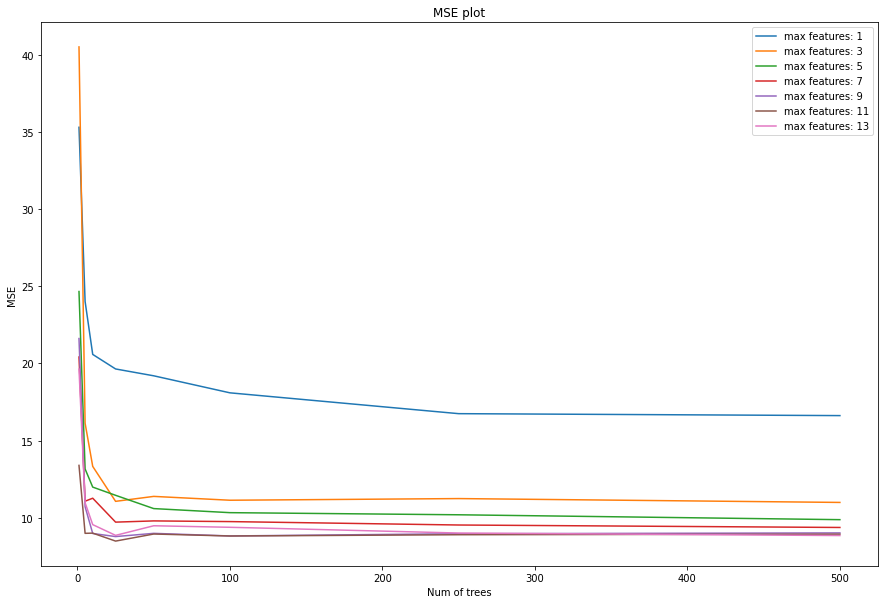

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
for col in errors.columns:
    ax.plot(errors.index, errors[col], label=f'max features: {col}')
ax.legend()
ax.set_title('MSE plot')
ax.set_xlabel('Num of trees')
ax.set_ylabel('MSE')

The plot shows that 100 trees is sufficient to get best results from random forest. Also models that consider 9 and 11 features at each split perform best.

# Ex. 8

In [10]:
dataset_file = '../datasets/Carseats.csv'

data = pd.read_csv(dataset_file)
data.Urban = data.Urban.apply(lambda v: 1 if v == 'Yes' else 0)
data.US = data.US.apply(lambda v: 1 if v == 'Yes' else 0)
data = pd.concat([data, pd.get_dummies(data.ShelveLoc, prefix='ShelveLoc', prefix_sep='')], axis=1)
data.drop(['ShelveLoc'], axis=1, inplace=True)
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLocBad,ShelveLocGood,ShelveLocMedium
0,9.50,138,73,11,276,120,42,17,1,1,1,0,0
1,11.22,111,48,16,260,83,65,10,1,1,0,1,0
2,10.06,113,35,10,269,80,59,12,1,1,0,0,1
3,7.40,117,100,4,466,97,55,14,1,1,0,0,1
4,4.15,141,64,3,340,128,38,13,1,0,1,0,0


In [11]:
train_data, test_data = train_test_split(data, test_size=.25, random_state=seed)

train_X, test_X = train_data.drop(['Sales'], axis=1), test_data.drop(['Sales'], axis=1)
train_y, test_y = train_data.Sales, test_data.Sales

In [26]:
model = tree.DecisionTreeRegressor(random_state=seed).fit(train_X, train_y)

Terminal nodes: 295
Training error: 0.0000
Test error: 5.9852
Mean deviance: 0.0000


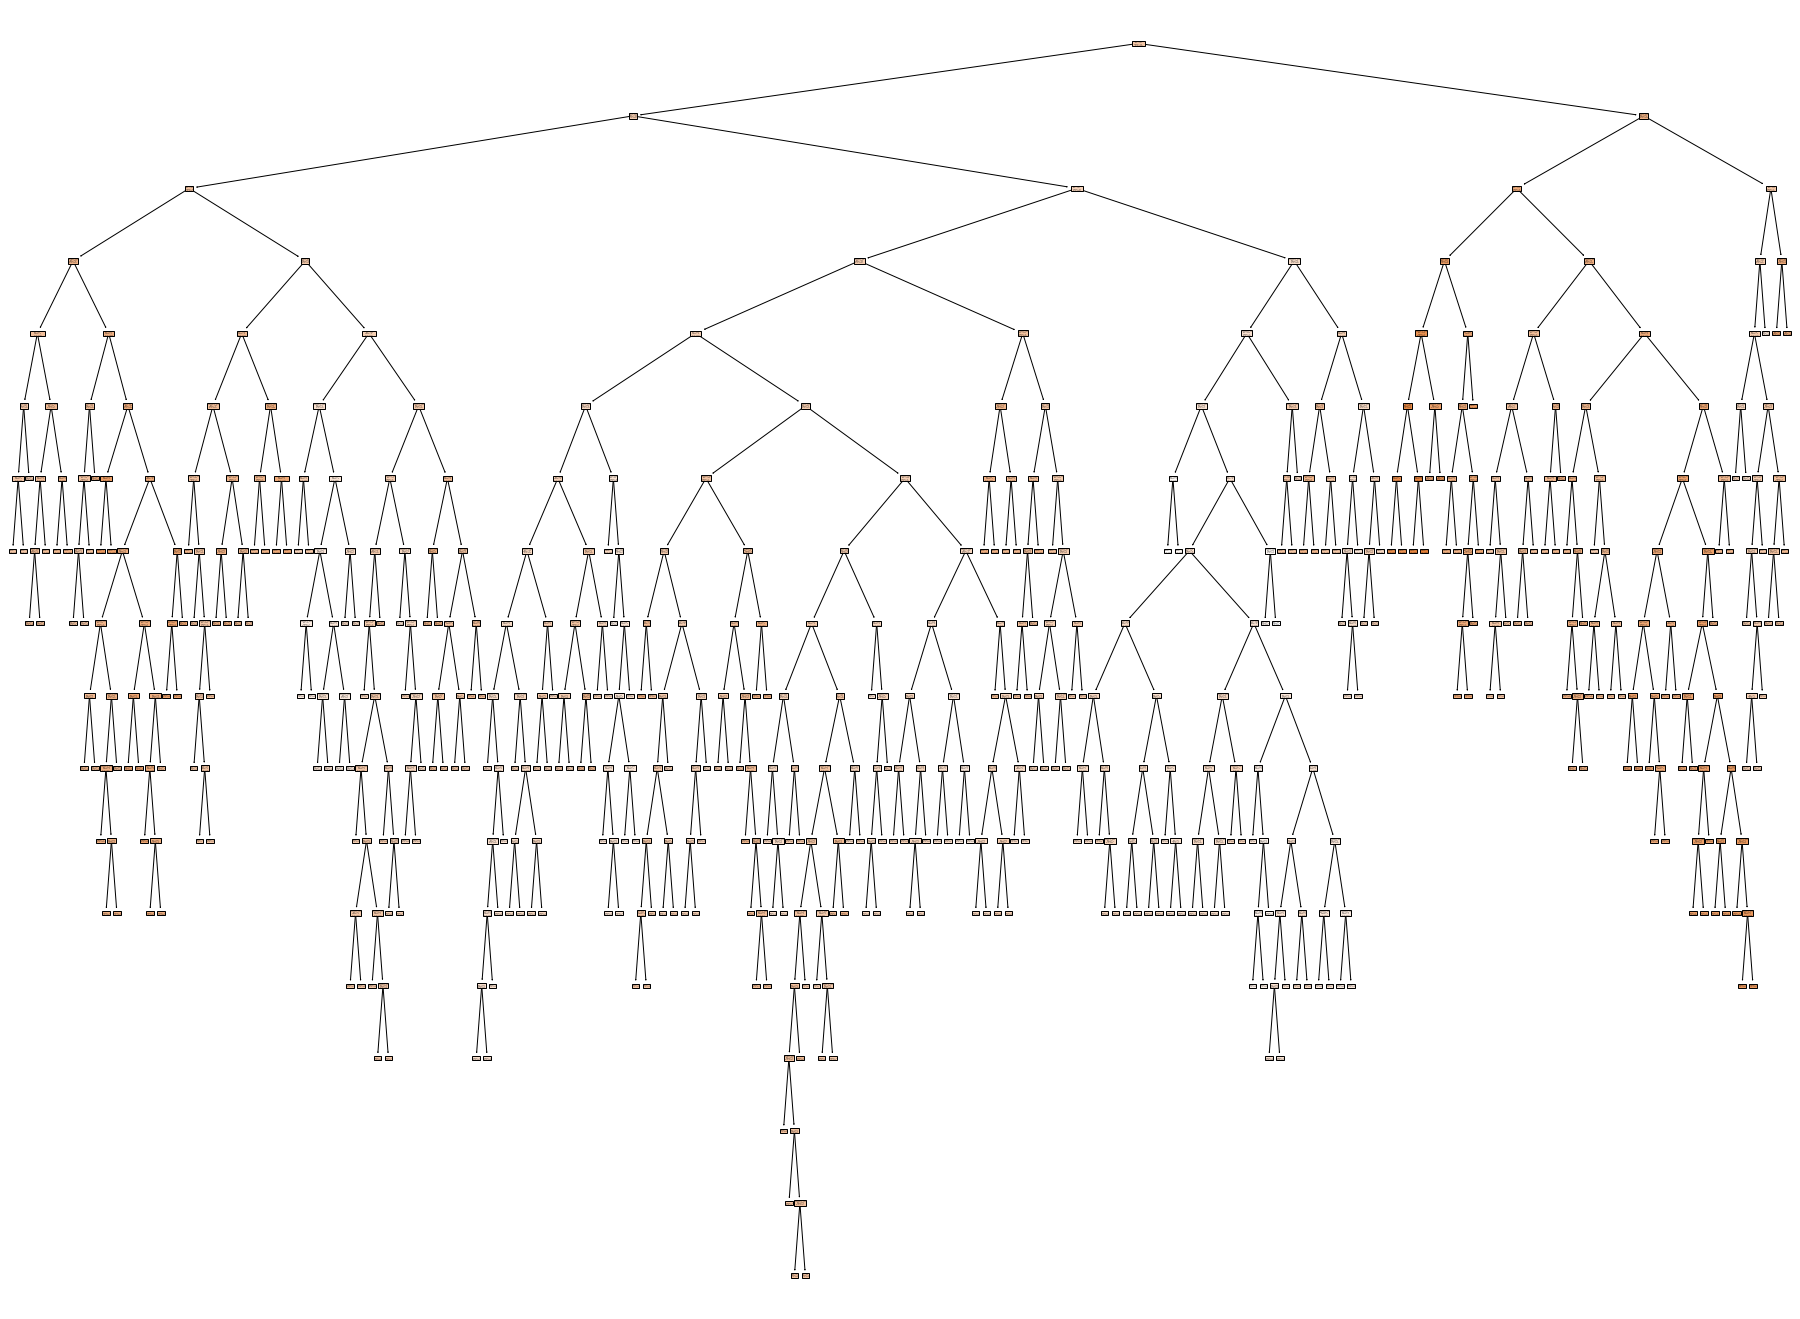

In [29]:
plt.figure(figsize=(32, 24))
cols = train_X.columns
tree.plot_tree(model, feature_names=cols, filled=True)

deviance = ((train_y - model.predict(train_X)) ** 2).sum()
print(f'Terminal nodes: {model.get_n_leaves()}')
print(f"Training error: {mean_squared_error(train_y, model.predict(train_X)):.4f}")
print(f"Test error: {mean_squared_error(test_y, model.predict(test_X)):.4f}")
print(f"Mean deviance: {deviance / (train_y.size - model.get_n_leaves()):.4f}")

In [30]:
def mse_scoring(est, X, y):
    return mean_squared_error(y, est.predict(X))

Text(0, 0.5, 'MSE')

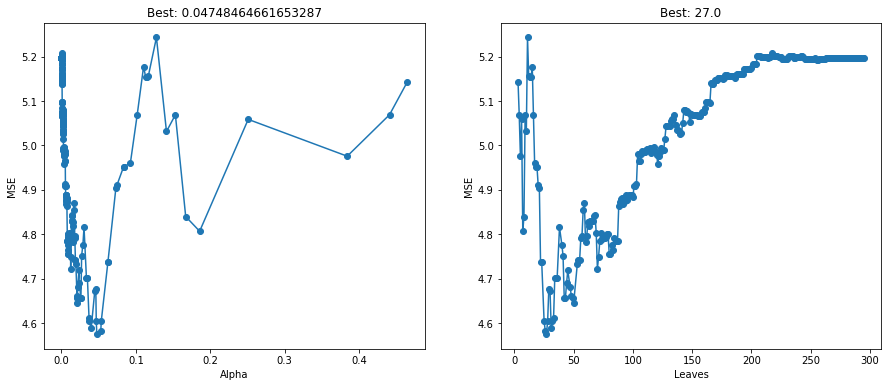

In [31]:
alphas = model.cost_complexity_pruning_path(train_X, train_y)['ccp_alphas'][:-2]
train_scores = pd.DataFrame(
    dtype=float,
    index=pd.RangeIndex(len(alphas)),
    columns=['alpha', 'mean', 'std', 'leaves']
)
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

for idx, alpha in enumerate(alphas):
    model = tree.DecisionTreeRegressor(random_state=seed, ccp_alpha=alpha)
    model.fit(train_X, train_y)
    leaves = model.get_n_leaves()
    scores = cross_val_score(model, train_X, train_y, scoring=mse_scoring, cv=cv)
    train_scores.iloc[idx] = alpha, scores.mean(), scores.std(), leaves

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
best = train_scores['mean'].idxmin()

axes[0].plot(train_scores.alpha, train_scores['mean'], 'o-')
axes[0].set_title(f"Best: {train_scores.iloc[best].alpha}")
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('MSE')

axes[1].plot(train_scores.leaves, train_scores['mean'], 'o-')
axes[1].set_title(f"Best: {train_scores.loc[best].leaves}")
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('MSE')

MSE: 5.4689
Leaves: 27


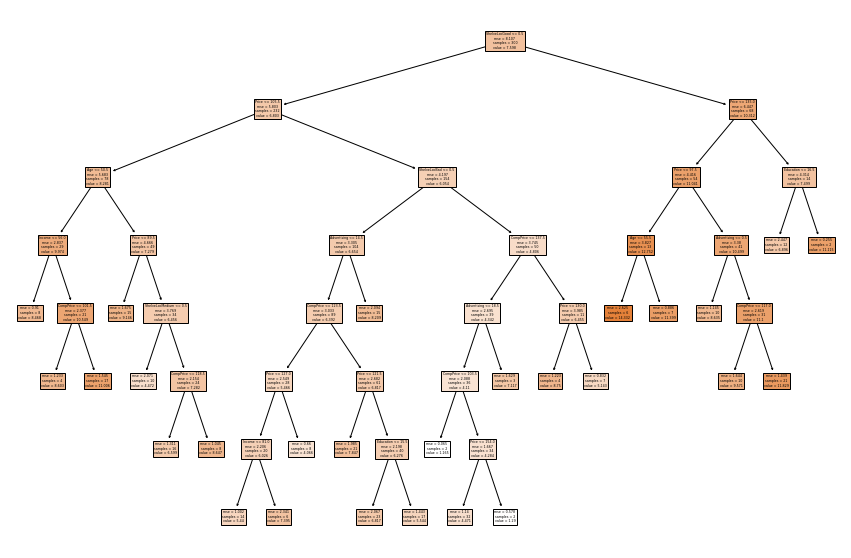

In [32]:
best_model = tree.DecisionTreeRegressor(random_state=seed, ccp_alpha=train_scores.iloc[best].alpha)
best_model.fit(train_X, train_y)
pred_y = best_model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

plt.figure(figsize=(15, 10))
tree.plot_tree(best_model, feature_names=cols, filled=True)

print(f'MSE: {mse:.4f}')
print(f'Leaves: {best_model.get_n_leaves()}')

Test MSE has improved slightly.

MSE: 2.8704


Text(0.5, 1.0, 'Feature importances')

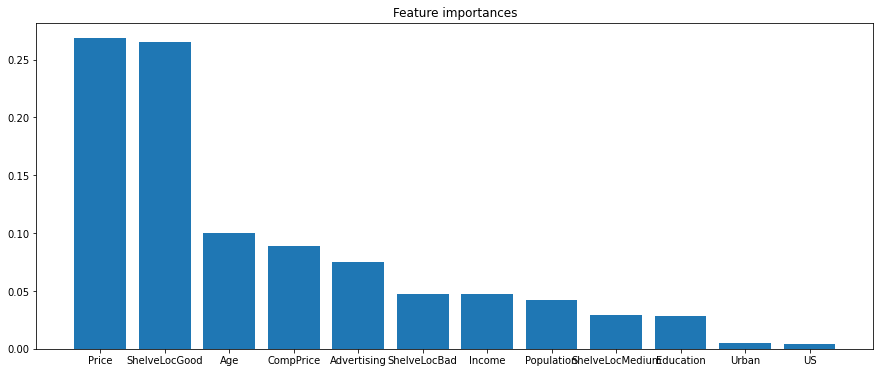

In [38]:
model = ensemble.BaggingRegressor(random_state=seed, n_estimators=100)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

print(f'MSE: {mse:.4f}')

importances = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)
importances_s = pd.Series({col: importances[i] for i, col in enumerate(train_X.columns)})
importances_s.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(importances_s.index, importances_s)
ax.set_title('Feature importances')

Test MSE has decreased dramatically.

In [46]:
vars_nums = np.arange(1, train_X.shape[1] + 1)
errors = pd.Series(index=vars_nums, dtype=float)

for vars_num in vars_nums:
    model = ensemble.RandomForestrestRegressor(
        random_state=seed,
        n_estimators=100,
        max_features=vars_num
    )
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)

    errors.loc[vars_num] = mean_squared_error(test_y, pred_y)

Text(0, 0.5, 'MSE')

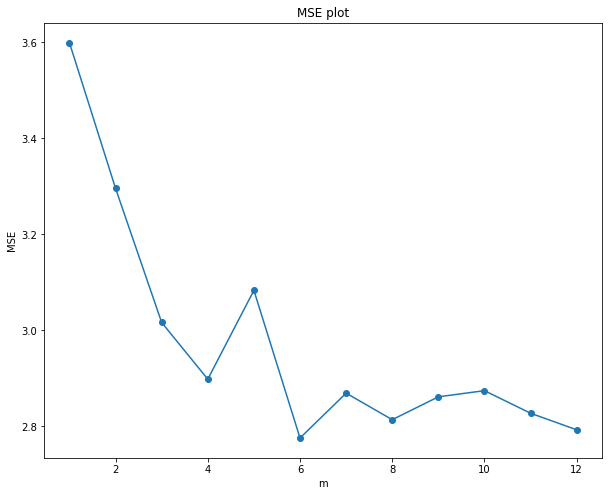

In [47]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(errors.index, errors, 'o-')
ax.set_title('MSE plot')
ax.set_xlabel('m')
ax.set_ylabel('MSE')

Mse differs for different number of max features, but has a tendention to go down with increasing of number of features. Lowest MSE belongs to model with 6 features.

MSE: 2.7756


Text(0.5, 1.0, 'Feature importances')

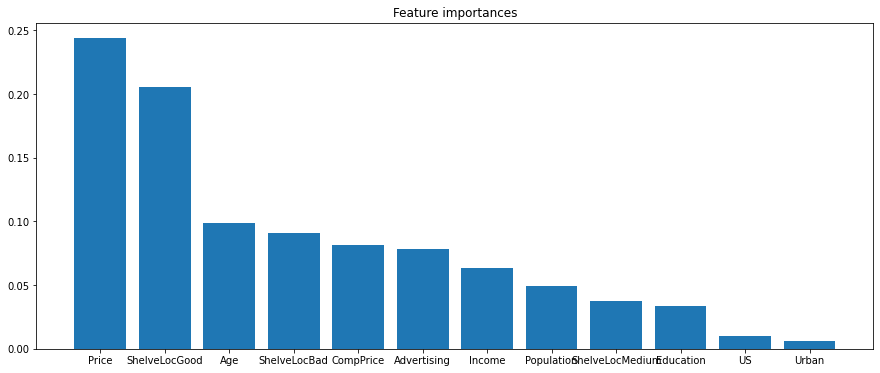

In [49]:
model = ensemble.RandomForestRegressor(random_state=seed, n_estimators=100, max_features=6)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

print(f'MSE: {mse:.4f}')

importances = pd.Series({col: model.feature_importances_[i] for i, col in enumerate(train_X.columns)})
importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(importances.index, importances)
ax.set_title('Feature importances')

Random forest has slightly decreased test MSE compared to bagging.

# Ex. 9

In [70]:
dataset_file = '../datasets/OJ.csv'

data = pd.read_csv(dataset_file)
data.Store7 = data.Store7.apply(lambda v: 1 if v == 'Yes' else 0)
data = pd.concat([data, pd.get_dummies(data.Purchase, prefix='Purchase', prefix_sep='')], axis=1)
data.drop(['Purchase', 'PurchaseMM'], axis=1, inplace=True)
data = pd.concat([data, pd.get_dummies(data.StoreID, prefix='StoreID', prefix_sep='')], axis=1)
data.drop(['STORE', 'StoreID', 'Store7'], axis=1, inplace=True)
data.head()

,WeekofPurchase,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,PurchaseCH,StoreID1,StoreID2,StoreID3,StoreID4,StoreID7
0,237,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0.000000,0.000000,0.24,1,1,0,0,0,0
1,239,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0.150754,0.000000,0.24,1,1,0,0,0,0
2,245,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0.000000,0.091398,0.23,1,1,0,0,0,0
3,227,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0.000000,0.000000,0.00,0,1,0,0,0,0
4,228,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,0.000000,0.000000,0.00,1,0,0,0,0,1


In [71]:
train_data, test_data = train_test_split(data, train_size=800, random_state=seed)

train_X, test_X = train_data.drop(['PurchaseCH'], axis=1), test_data.drop(['PurchaseCH'], axis=1)
train_y, test_y = train_data.PurchaseCH, test_data.PurchaseCH

In [97]:
model = tree.DecisionTreeClassifier(random_state=seed).fit(train_X, train_y)

In [75]:
from collections import Counter

leaves_count = Counter()
n1 = Counter()
n0 = Counter()
for X, y in zip(train_X.to_numpy(), train_y):
    terminal = model.apply(X.reshape(1, -1))[0]
    leaves_count[terminal] += 1
    if y == 1:
        n1[terminal] += 1
    else:
        n0[terminal] += 1

deviance = -2 * np.sum([n1[leaf] * np.log(n1[leaf] / leaves_count[leaf] + 1e-6) + \
                        n0[leaf] * np.log(n0[leaf] / leaves_count[leaf] + 1e-6) 
                        for leaf in leaves_count.keys()])

Terminal nodes: 159
Training error: 0.0100
Mean deviance: 0.0379


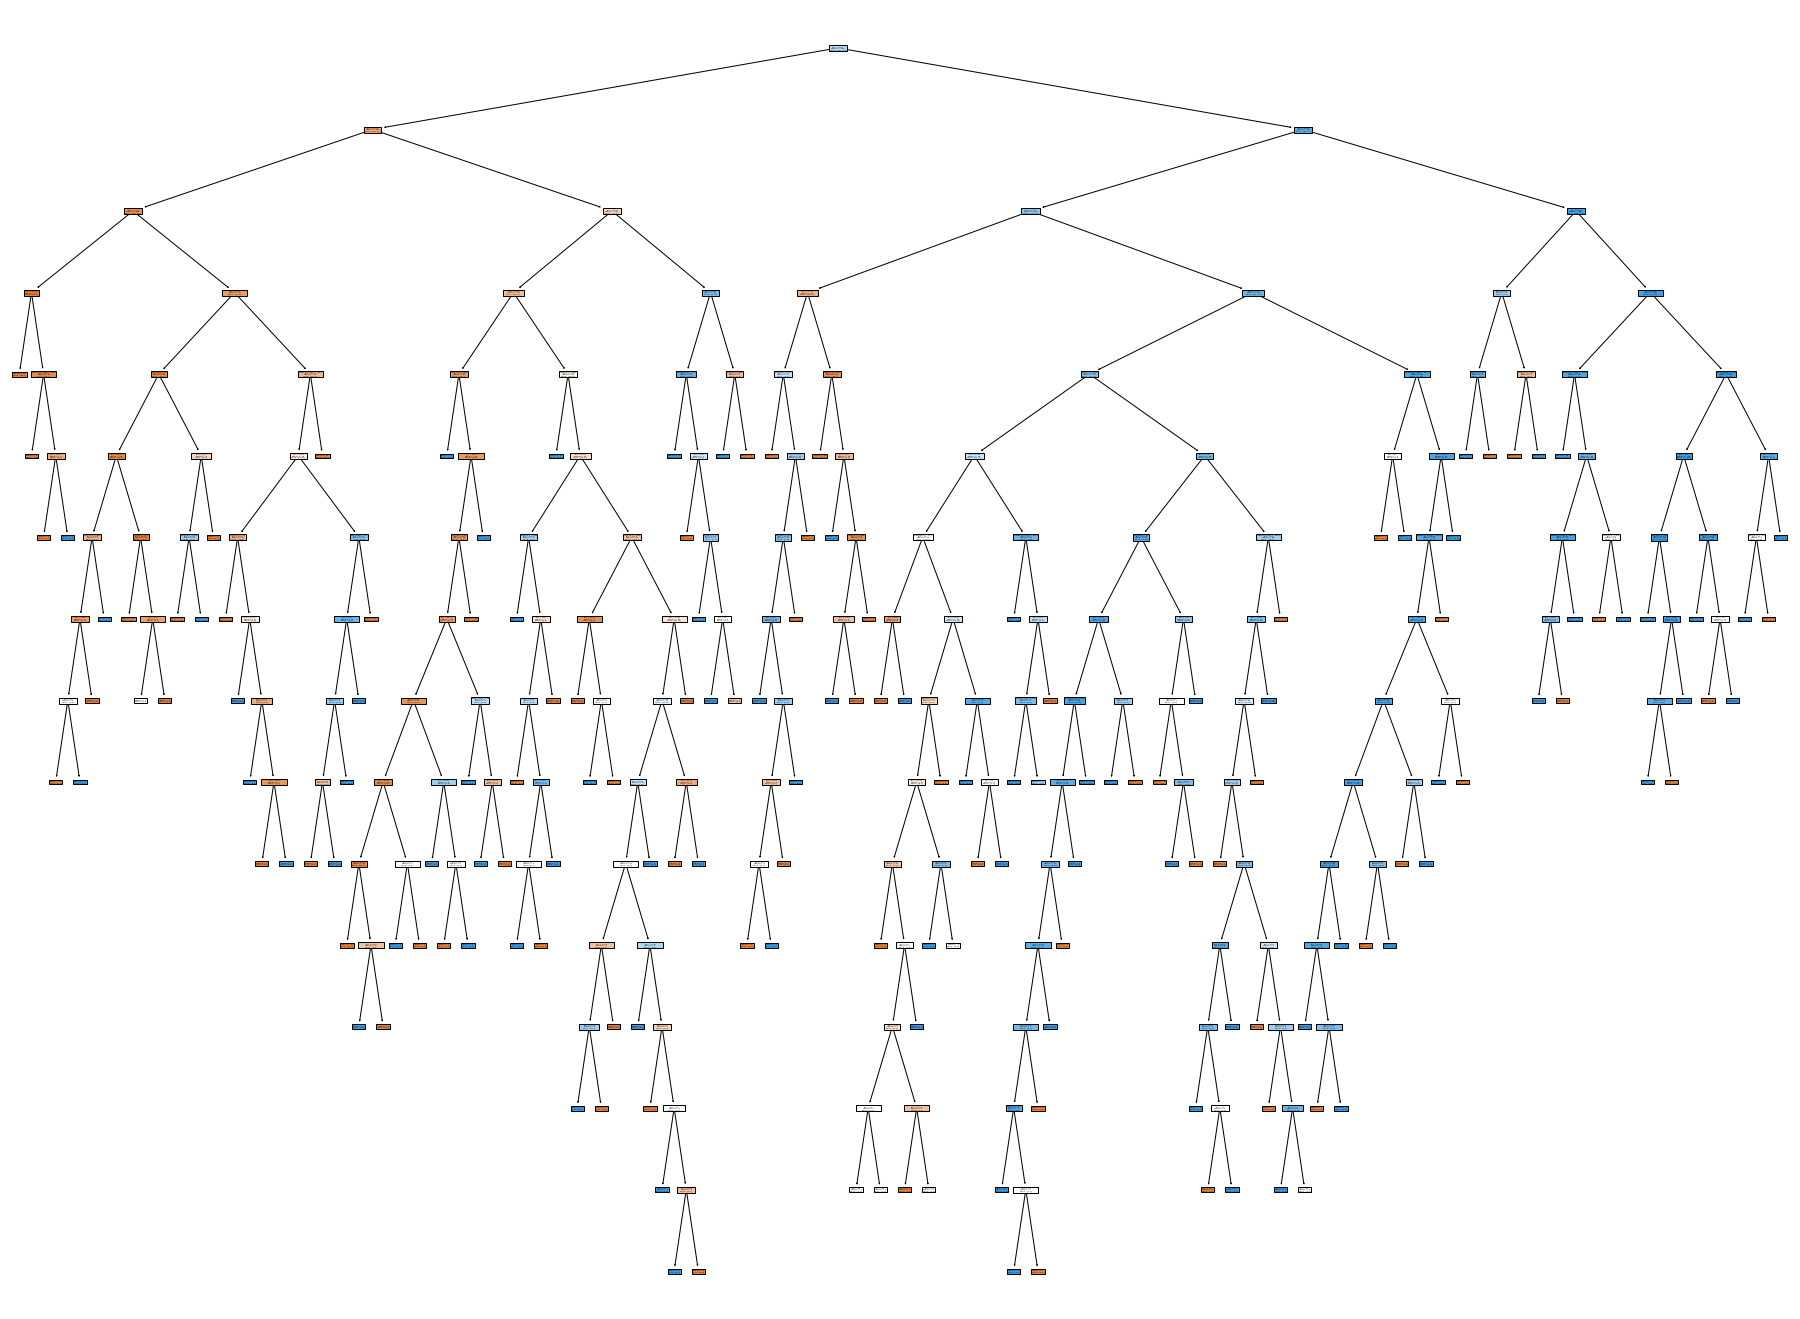

In [77]:
plt.figure(figsize=(32, 24))
cols = train_X.columns
tree.plot_tree(model, feature_names=cols, filled=True)

print(f'Terminal nodes: {model.get_n_leaves()}')
print(f"Training error: {1 - model.score(train_X, train_y):.4f}")
print(f"Mean deviance: {deviance / (train_y.size - model.get_n_leaves()):.4f}")

In [78]:
print(tree.export_text(model, feature_names=list(cols)))

|--- LoyalCH <= 0.45
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.05
|   |   |   |--- StoreID2 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- StoreID2 >  0.50
|   |   |   |   |--- WeekofPurchase <= 268.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- WeekofPurchase >  268.00
|   |   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- LoyalCH >  0.00
|   |   |   |   |   |   |--- class: 1
|   |   |--- LoyalCH >  0.05
|   |   |   |--- WeekofPurchase <= 249.50
|   |   |   |   |--- StoreID1 <= 0.50
|   |   |   |   |   |--- LoyalCH <= 0.09
|   |   |   |   |   |   |--- LoyalCH <= 0.08
|   |   |   |   |   |   |   |--- LoyalCH <= 0.07
|   |   |   |   |   |   |   |   |--- LoyalCH <= 0.06
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- LoyalCH >  0.06
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- LoyalCH >  0.07
|   |   |   |   |   |   |   |   |--- class: 

The simplest node suggests that if LoyalCH <= 0.05 and StoreID is not 2, then target class is MM.

Train error rate: 0.010
Test error rate: 0.244


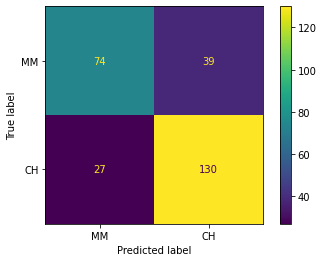

In [98]:
train_acc = model.score(train_X, train_y)
test_acc = model.score(test_X, test_y)
print(f'Train error rate: {1 - train_acc:.3f}')
print(f'Test error rate: {1 - test_acc:.3f}')
plot_confusion_matrix(model, test_X, test_y, display_labels=['MM', 'CH'])

Text(0, 0.5, 'Error')

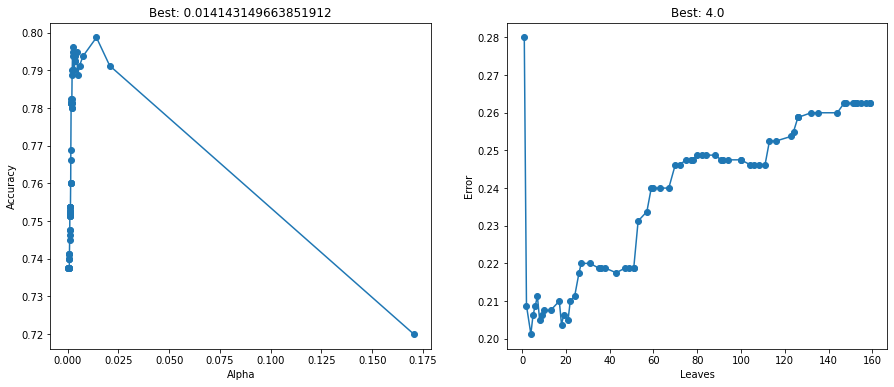

In [102]:
alphas = model.cost_complexity_pruning_path(train_X, train_y)['ccp_alphas']
train_scores = pd.DataFrame(
    dtype=float,
    index=pd.RangeIndex(len(alphas)),
    columns=['alpha', 'mean', 'std', 'leaves']
)
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

for idx, alpha in enumerate(alphas):
    model = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=alpha)
    model.fit(train_X, train_y)
    leaves = model.get_n_leaves()
    scores = cross_val_score(model, train_X, train_y, cv=cv)
    train_scores.iloc[idx] = alpha, scores.mean(), scores.std(), leaves

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
best = train_scores['mean'].idxmax()

axes[0].plot(train_scores.alpha, train_scores['mean'], 'o-')
axes[0].set_title(f"Best: {train_scores.iloc[best].alpha}")
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Accuracy')

axes[1].plot(train_scores.leaves, 1 - train_scores['mean'], 'o-')
axes[1].set_title(f"Best: {train_scores.loc[best].leaves}")
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('Error')

Train error rate: 0.165
Test error rate: 0.181
Leaves: 4


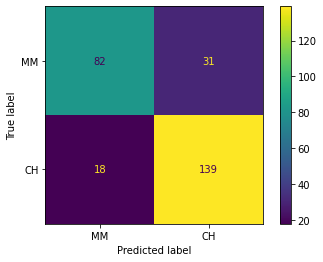

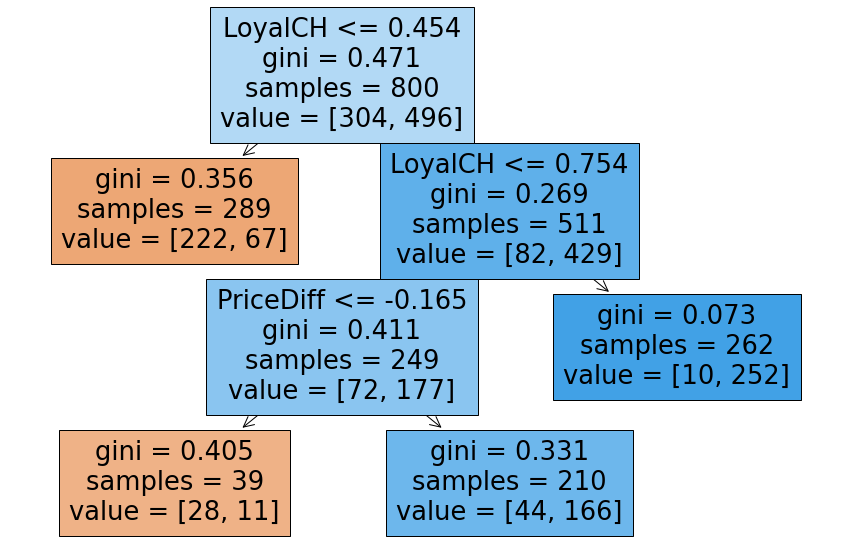

In [104]:
best_model = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=train_scores.iloc[best].alpha)
best_model.fit(train_X, train_y)
pred_y = best_model.predict(test_X)

plot_confusion_matrix(best_model, test_X, test_y, display_labels=['MM', 'CH'])
plt.figure(figsize=(15, 10))
tree.plot_tree(best_model, feature_names=cols, filled=True)

train_acc = best_model.score(train_X, train_y)
test_acc = best_model.score(test_X, test_y)
print(f'Train error rate: {1 - train_acc:.3f}')
print(f'Test error rate: {1 - test_acc:.3f}')
print(f'Leaves: {best_model.get_n_leaves()}')

Pruned Tree has higher train error, but lower test error.